## All Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import datetime as dt
from dateutil.parser import *
import random
import time
import json
from numpy import argmax
import warnings
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, accuracy_score, \
precision_score, f1_score, recall_score, roc_curve, auc, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import re
import seaborn as sns
from imblearn.over_sampling import SMOTE 

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

%config InlineBackend.figure_format = 'retina'
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Reading in datasets

In [43]:
df_regression = pd.read_csv('../data/merged_train_final.csv')
df_multi = pd.read_csv('../data/merged_train_multi.csv')

test_df_regression = pd.read_csv('../data/merged_test_final.csv')
test_df_multi = pd.read_csv('../data/merged_test_multi.csv')

In [4]:
# defining x and y for our dataset with multi-collinearity
x = df_multi.drop(['wnvpresent'],axis=1)
y = df_multi['wnvpresent']

y.value_counts(normalize=True)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

As we can see from the above output, our target `y` is very imbalanced. It is not advisable to conduct modeling on such a dataset, as such we will be using a technique known as **Synthetic Minority Oversampling Technique** (SMOTE for short) to help us rebalance the two classes before we do any modeling.

In [5]:
# train_test_split on our previously defined x and y
x_train, x_test, y_train, y_test= train_test_split(x,y,random_state=42)

# scaling our features before using SMOTE
ss = StandardScaler()
x_train_sc = ss.fit_transform(x_train)
x_test_sc = ss.transform(x_test)

In [6]:
# initialize SMOTE
sm = SMOTE(random_state=42)

# resample on our train data
x_train_sc, y_train = sm.fit_resample(x_train_sc,y_train)

# sanity check to ensure our classes are balanced now
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: wnvpresent, dtype: float64

In [3]:
# Instantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'svm': SVC(random_state=42, probability=True),
          'xgb': XGBClassifier(random_state=42)
}

In [4]:
# Function to run model -- input model
def get_model_scores(model_name,
                     mod, 
                     mod_params={}, 
                     grid_search=False):
    
    """Function accepts following inputs:
    Name of model (str), model to be used (str), 
    model params(dict, optional), grid_seach(boolean, optional)
    If grid_search is True, then please also input the relevant 
    params for GridSearching
    """
    
    # empty dict for appending results
    results = {}
    
    # instantiate pipe
    pipe = Pipeline([
            (mod, models[mod])
            ])
    
    # check if GridSearch true or false
    if grid_search:
        
        # combine vectorizer and mod params together
        gs_params = {}
        gs_params.update(mod_params)
        
        # instantiate GridSearchCV
        gs = GridSearchCV(pipe, 
                          param_grid=gs_params,
                          cv=5, 
                          verbose=2, 
                          n_jobs=-1)
        
        # fit model
        gs.fit(x_train_sc, y_train)
        pipe = gs
        
    else:
        # else fit model
        pipe.fit(x_train_sc, y_train)
    
    # create predictions and confusion matrix
    predictions = pipe.predict(x_test_sc)
    tn, fp, fn, tp = confusion_matrix(y_test, 
                                      predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(x_test_sc)[:,1]
    y_train_pred_prob = pipe.predict_proba(x_train_sc)[:,1]

    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    
    # Retrieve metrics and add to results
    results['model_name'] = model_name
    results['model'] = mod
    results['train_score'] = pipe.score(x_train_sc, y_train)
    results['test_score'] = pipe.score(x_test_sc, y_test)
    
    results['recall'] = recall_score(y_test, 
                                     predictions)
    
    results['specificity'] = tn/(tn + fp)
    
    results['precision'] = precision_score(y_test, 
                                           predictions)
    
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    
    results['is_tuned'] = grid_search
    fpr, tpr, thresholds = roc_curve(y_test, lr_base_multi.predict(x_test_sc))
    results['fpr'] = fpr
    results['tpr'] = tpr
    
    if grid_search:
        print('BEST PARAMS-->')
        display(pipe.best_params_)
    
    # add results to list for model evaluation later
    model_eval.append(results)
    
    print('METRICS-->')
    display(results)
    
    tn, fp, fn, tp = confusion_matrix(y_test, 
                                      predictions).ravel()
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [5]:
# create list to store results
model_eval =[]

## Baseline Models

For this section, we will not be adding any parameters to our models in order to have a baseline for each model. 

### Dataset with Features with multicollinearity

In [156]:
lr_base_multi.steps[0][1].n_features_in_

157

In [70]:
lr_base_multi = get_model_scores('lr_base_multi', 'lr')

METRICS-->


{'model_name': 'lr_base_multi',
 'model': 'lr',
 'train_score': 0.8259796806966618,
 'test_score': 0.775990099009901,
 'recall': 0.6048387096774194,
 'specificity': 0.7852173913043479,
 'precision': 0.13181019332161686,
 'train_auc': 0.8874044228083443,
 'test_auc': 0.7729926367461429,
 'is_tuned': False}

True Negatives: 1806
False Positives: 494
False Negatives: 49
True Positives: 75


In [71]:
svm_base_multi = get_model_scores('svm_base_multi', 'svm')

METRICS-->


{'model_name': 'svm_base_multi',
 'model': 'svm',
 'train_score': 0.9298984034833091,
 'test_score': 0.8535478547854786,
 'recall': 0.45161290322580644,
 'specificity': 0.8752173913043478,
 'precision': 0.16326530612244897,
 'train_auc': 0.9783968162352202,
 'test_auc': 0.777312412342216,
 'is_tuned': False}

True Negatives: 2013
False Positives: 287
False Negatives: 68
True Positives: 56


In [72]:
xg_base_multi = get_model_scores('xg_base_multi', 'xgb')

[19:48:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


METRICS-->


{'model_name': 'xg_base_multi',
 'model': 'xgb',
 'train_score': 0.978011611030479,
 'test_score': 0.9422442244224423,
 'recall': 0.0967741935483871,
 'specificity': 0.9878260869565217,
 'precision': 0.3,
 'train_auc': 0.9974362836276467,
 'test_auc': 0.8528962131837308,
 'is_tuned': False}

True Negatives: 2272
False Positives: 28
False Negatives: 112
True Positives: 12


In [73]:
rf_base_multi = get_model_scores('rf_base_multi', 'rf')

METRICS-->


{'model_name': 'rf_base_multi',
 'model': 'rf',
 'train_score': 0.9918722786647315,
 'test_score': 0.9434818481848185,
 'recall': 0.07258064516129033,
 'specificity': 0.9904347826086957,
 'precision': 0.2903225806451613,
 'train_auc': 0.9997484522487946,
 'test_auc': 0.7970950210378681,
 'is_tuned': False}

True Negatives: 2278
False Positives: 22
False Negatives: 115
True Positives: 9


In [74]:
et_base_multi = get_model_scores('et_base_multi', 'et')

METRICS-->


{'model_name': 'et_base_multi',
 'model': 'et',
 'train_score': 0.9918722786647315,
 'test_score': 0.9426567656765676,
 'recall': 0.06451612903225806,
 'specificity': 0.99,
 'precision': 0.25806451612903225,
 'train_auc': 0.9998393056131918,
 'test_auc': 0.70117110799439,
 'is_tuned': False}

True Negatives: 2277
False Positives: 23
False Negatives: 116
True Positives: 8


In [75]:
gb_base_multi = get_model_scores('gb_base_multi', 'gb')

METRICS-->


{'model_name': 'gb_base_multi',
 'model': 'gb',
 'train_score': 0.9555152394775036,
 'test_score': 0.9377062706270627,
 'recall': 0.20161290322580644,
 'specificity': 0.9773913043478261,
 'precision': 0.3246753246753247,
 'train_auc': 0.9905579909041311,
 'test_auc': 0.8335729312762974,
 'is_tuned': False}

True Negatives: 2248
False Positives: 52
False Negatives: 99
True Positives: 25


In [76]:
ada_base_multi = get_model_scores('ada_base_multi', 'ada')

METRICS-->


{'model_name': 'ada_base_multi',
 'model': 'ada',
 'train_score': 0.9322931785195936,
 'test_score': 0.9129537953795379,
 'recall': 0.3870967741935484,
 'specificity': 0.941304347826087,
 'precision': 0.26229508196721313,
 'train_auc': 0.9820600415823189,
 'test_auc': 0.8415410238429173,
 'is_tuned': False}

True Negatives: 2165
False Positives: 135
False Negatives: 76
True Positives: 48


### Dataset with Features with minimal multicollinearity

First we will have to reset our `x` and `y` for the new dataset to feed into our modeling function.

In [77]:
# redefining our x, y for the new dataset
x = df_regression.drop(['wnvpresent'],axis=1)
y = df_regression['wnvpresent']

# check for imbalance, 
# expected to be same as previously seen
y.value_counts(normalize=True)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

In [78]:
# train_test_split on our previously defined x and y
x_train, x_test, y_train, y_test= train_test_split(x,y,random_state=42)

# scaling our features before using SMOTE
ss = StandardScaler()
x_train_sc = ss.fit_transform(x_train)
x_test_sc = ss.transform(x_test)

In [79]:
# initialize SMOTE
sm = SMOTE(random_state=42)

# resample on our train data
x_train_sc, y_train = sm.fit_resample(x_train_sc,y_train)

# sanity check to ensure our classes are balanced now
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: wnvpresent, dtype: float64

Now we are ready to begin modeling for the dataset with minimal multi-collinearity. For simplicity's sake, we will refer to these models with the suffix `_reg`.

In [80]:
lr_base_reg = get_model_scores('lr_base_reg', 'lr')

METRICS-->


{'model_name': 'lr_base_reg',
 'model': 'lr',
 'train_score': 0.8057329462989841,
 'test_score': 0.7541254125412541,
 'recall': 0.5887096774193549,
 'specificity': 0.7630434782608696,
 'precision': 0.11812297734627832,
 'train_auc': 0.8751527212826059,
 'test_auc': 0.7461448106591865,
 'is_tuned': False}

True Negatives: 1755
False Positives: 545
False Negatives: 51
True Positives: 73


In [81]:
svm_base_reg = get_model_scores('svm_base_reg', 'svm')

METRICS-->


{'model_name': 'svm_base_reg',
 'model': 'svm',
 'train_score': 0.9130624092888244,
 'test_score': 0.8407590759075908,
 'recall': 0.4274193548387097,
 'specificity': 0.8630434782608696,
 'precision': 0.14402173913043478,
 'train_auc': 0.9712810577160058,
 'test_auc': 0.7514708976157083,
 'is_tuned': False}

True Negatives: 1985
False Positives: 315
False Negatives: 71
True Positives: 53


In [82]:
xg_base_reg = get_model_scores('xg_base_reg', 'xgb')

[19:51:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


METRICS-->


{'model_name': 'xg_base_reg',
 'model': 'xgb',
 'train_score': 0.9776487663280116,
 'test_score': 0.9426567656765676,
 'recall': 0.08064516129032258,
 'specificity': 0.9891304347826086,
 'precision': 0.2857142857142857,
 'train_auc': 0.9971802490304831,
 'test_auc': 0.8572072230014025,
 'is_tuned': False}

True Negatives: 2275
False Positives: 25
False Negatives: 114
True Positives: 10


In [83]:
rf_base_reg = get_model_scores('rf_base_reg', 'rf')

METRICS-->


{'model_name': 'rf_base_reg',
 'model': 'rf',
 'train_score': 0.9918722786647315,
 'test_score': 0.9418316831683168,
 'recall': 0.06451612903225806,
 'specificity': 0.9891304347826086,
 'precision': 0.24242424242424243,
 'train_auc': 0.9997510643093522,
 'test_auc': 0.7902559607293127,
 'is_tuned': False}

True Negatives: 2275
False Positives: 25
False Negatives: 116
True Positives: 8


In [84]:
et_base_reg = get_model_scores('et_base_reg', 'et')

METRICS-->


{'model_name': 'et_base_reg',
 'model': 'et',
 'train_score': 0.9918722786647315,
 'test_score': 0.941006600660066,
 'recall': 0.07258064516129033,
 'specificity': 0.9878260869565217,
 'precision': 0.24324324324324326,
 'train_auc': 0.9998393056131918,
 'test_auc': 0.6866374474053296,
 'is_tuned': False}

True Negatives: 2272
False Positives: 28
False Negatives: 115
True Positives: 9


In [85]:
gb_base_reg = get_model_scores('gb_base_reg', 'gb')

METRICS-->


{'model_name': 'gb_base_reg',
 'model': 'gb',
 'train_score': 0.9613207547169811,
 'test_score': 0.9389438943894389,
 'recall': 0.12903225806451613,
 'specificity': 0.9826086956521739,
 'precision': 0.2857142857142857,
 'train_auc': 0.9908925453055584,
 'test_auc': 0.8262903225806452,
 'is_tuned': False}

True Negatives: 2260
False Positives: 40
False Negatives: 108
True Positives: 16


In [86]:
ada_base_reg = get_model_scores('ada_base_reg', 'ada')

METRICS-->


{'model_name': 'ada_base_reg',
 'model': 'ada',
 'train_score': 0.9402757619738752,
 'test_score': 0.9261551155115512,
 'recall': 0.18548387096774194,
 'specificity': 0.9660869565217391,
 'precision': 0.22772277227722773,
 'train_auc': 0.9831208330787979,
 'test_auc': 0.8237394810659187,
 'is_tuned': False}

True Negatives: 2222
False Positives: 78
False Negatives: 101
True Positives: 23


Now let's evaluate all our models and see which model, and which dataset has performed the best. Based on this, we will decide which models to further tune.<br>
The main metrics we are looking for are `recall` and `test_auc`.

In [87]:
base_model_scores = pd.DataFrame(model_eval)

base_model_scores.sort_values(by=['recall', 
                                  'test_auc'], 
                              ascending=False)[['model_name', 
                                                'model','recall', 
                                                'test_auc']]

,model_name,model,recall,test_auc
0,lr_base_multi,lr,0.604839,0.772993
7,lr_base_reg,lr,0.588710,0.746145
1,svm_base_multi,svm,0.451613,0.777312
8,svm_base_reg,svm,0.427419,0.751471
6,ada_base_multi,ada,0.387097,0.841541
5,gb_base_multi,gb,0.201613,0.833573
13,ada_base_reg,ada,0.185484,0.823739
12,gb_base_reg,gb,0.129032,0.826290
2,xg_base_multi,xgb,0.096774,0.852896
9,xg_base_reg,xgb,0.080645,0.857207


Since our scores are better using the dataset with features having multi-collinearity, we will continue using that dataset moving foward.

In [88]:
# saving our base_model_scores to csv in order to refer to them again if required.
base_model_scores.to_csv('../data/base_model_scores.csv')

In [27]:
# creating function to plot ROC curve
def roc_curve_plotter(model_dict, plot_top=False):
    """Doc String"""
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    auc_scores = []
    for i, m in enumerate(model_dict.keys()):
        fpr, tpr, thresholds = roc_curve(y_test, m.predict(x_test_sc))
        auc_scores[i] = auc(fpr, tpr)
        axes[f'ax{i}'] = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_scores[i], name=model_dict[m])
    if plot_top:
        max_index = auc_scores.index(max(auc_scores))
        for i, a in enumerate(axes):
            if i != max_index:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

In [126]:
# creating dictionary for ROC curve plotter
base_model_dict= {
    lr_base_multi: 'LogReg_MC',
    svm_base_multi: 'SVM_MC',
    xg_base_multi: 'XGBoost_MC',
    rf_base_multi: 'RandForest_MC',
    et_base_multi: 'ExtraTrees_MC',
    gb_base_multi: 'GradBoost_MC', 
    ada_base_multi: 'AdaBoost_MC',
    lr_base_reg: 'LogReg_reg',
    svm_base_reg: 'SVM_reg',
    xg_base_reg: 'XGBoost_reg', 
    rf_base_reg: 'RandForest_reg', 
    et_base_reg: 'ExtraTrees_reg',
    gb_base_reg: 'GradBoost_reg', 
    ada_base_reg: 'AdaBoost_reg'}

ValueError: X has 168 features, but LogisticRegression is expecting 157 features as input.

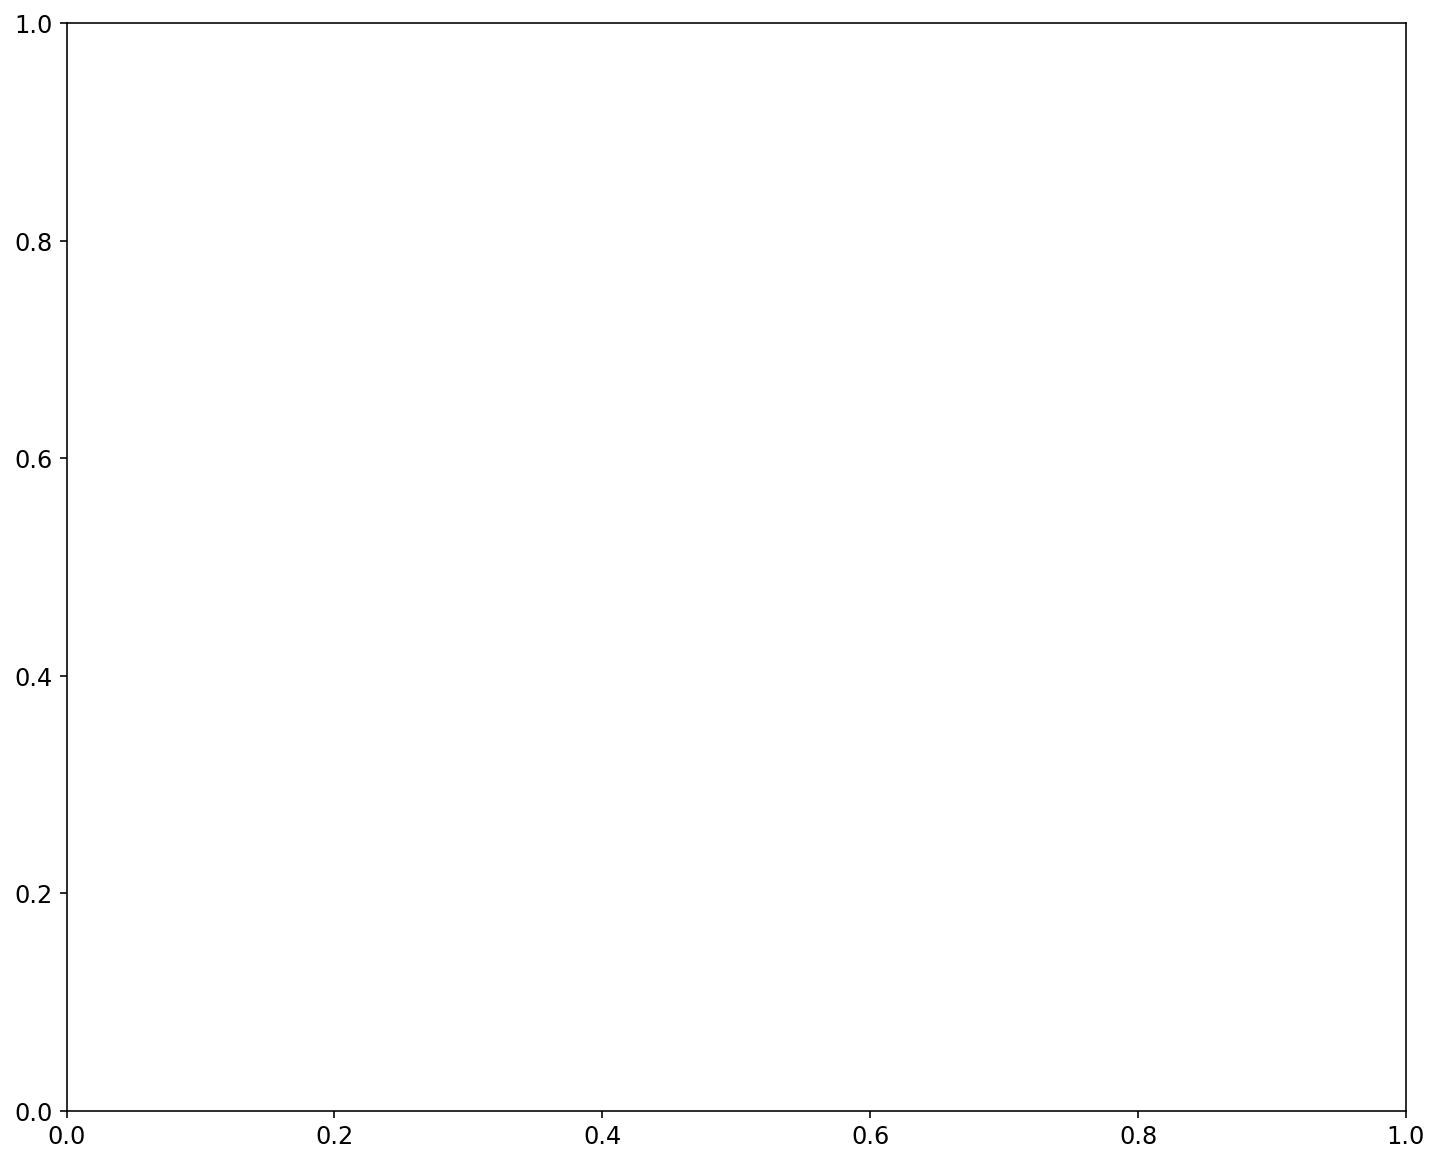

In [127]:
roc_curve_plotter(base_model_dict)

In [ ]:
roc_curve_plotter(base_model_dict, plot_top=True)

## Tuning our model

Considering that we want to optimize our models for *recall* and *AUC_ROC* scores, we will tune our models for each of these scores, and check their effectiveness against our test data (from `train_test_split`) to see which gives us the best result. <br>
As mentioned before, we will only be using the dataset with multi-collinearity as that performed better previously.

In [21]:
# redefining our model training function with scoring argument

# Function to run model -- input model
# the 'cs' in the function name stands for 'custom scoring'
def get_model_scores_cs(model_name,
                     mod, 
                     mod_params={}, 
                     grid_search=False, 
                     scoring=None):
    
    """Function accepts following inputs:
    Name of model (str), model to be used (str), 
    model params(dict, optional), grid_seach(boolean, optional)
    If grid_search is True, then please also input the relevant 
    params for GridSearching
    """
    
    # empty dict for appending results
    results = {}
    
    # instantiate pipe
    pipe = Pipeline([
            (mod, models[mod])
            ])
    
    # check if GridSearch true or false
    if grid_search:
        
        # combine vectorizer and mod params together
        gs_params = {}
        gs_params.update(mod_params)
        
        # instantiate GridSearchCV
        gs = GridSearchCV(pipe, 
                          param_grid=gs_params,
                          cv=5,
                          scoring=scoring,
                          verbose=2, 
                          n_jobs=-1)
        
        # fit model
        gs.fit(x_train_sc, y_train)
        pipe = gs
        
    else:
        # else fit model
        pipe.fit(x_train_sc, y_train)
    
    # create predictions and confusion matrix
    predictions = pipe.predict(x_test_sc)
    tn, fp, fn, tp = confusion_matrix(y_test, 
                                      predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(x_test_sc)[:,1]
    y_train_pred_prob = pipe.predict_proba(x_train_sc)[:,1]

    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    
    # Retrieve metrics and add to results
    results['model_name'] = model_name
    results['model'] = mod
    results['train_score'] = pipe.score(x_train_sc, y_train)
    results['test_score'] = pipe.score(x_test_sc, y_test)
    
    results['recall'] = recall_score(y_test, 
                                     predictions)
    
    results['specificity'] = tn/(tn + fp)
    
    results['precision'] = precision_score(y_test, 
                                           predictions)
    
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    
    results['is_tuned'] = grid_search
    
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    results['fpr'] = fpr
    results['tpr'] = tpr
    
    if grid_search:
        print('BEST PARAMS-->')
        display(pipe.best_params_)
    
    # add results to list for model evaluation later
    model_eval.append(results)
    
    print('METRICS-->')
    display(results)
    
    tn, fp, fn, tp = confusion_matrix(y_test, 
                                      predictions).ravel()
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [7]:
# create list to store results
model_eval =[]

### re-splitting train_test_split for dataset with features having multi-collinearity

In [8]:
x = df_multi.drop(['wnvpresent'],axis=1)
y = df_multi['wnvpresent']

y.value_counts(normalize=True)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

In [9]:
x_train, x_test, y_train, y_test= train_test_split(x,y,random_state=42)

ss = StandardScaler()
x_train_sc = ss.fit_transform(x_train)
x_test_sc = ss.transform(x_test)

In [10]:
sm = SMOTE(random_state=42)

x_train_sc, y_train = sm.fit_resample(x_train_sc,y_train)

y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: wnvpresent, dtype: float64

In [11]:
# defining each model's tuning parameters

ada_params = {'ada__n_estimators': [500, 1000, 1500],
              'ada__learning_rate': [0.9, 0.95, 1.0]
             }

gb_params = {'gb__n_estimators': [500, 1000, 1500],
             'gb__learning_rate': [0.2, 0.3, 0.4, 0.5],
}

In [24]:
gb_tuned_recall = get_model_scores_cs('gb_tuned_recall', 'gb', mod_params=gb_params, grid_search=True, scoring='recall')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
BEST PARAMS-->


{'gb__learning_rate': 0.4, 'gb__n_estimators': 1000}

METRICS-->


{'model_name': 'gb_tuned_recall',
 'model': 'gb',
 'train_score': 0.9824383164005805,
 'test_score': 0.20161290322580644,
 'recall': 0.20161290322580644,
 'specificity': 0.9739130434782609,
 'precision': 0.29411764705882354,
 'train_auc': 0.9987059030462103,
 'test_auc': 0.844773842917251,
 'is_tuned': True}

True Negatives: 2240
False Positives: 60
False Negatives: 99
True Positives: 25


In [25]:
gb_tuned_roc_auc = get_model_scores_cs('gb_tuned_roc_auc', 'gb', mod_params=gb_params, grid_search=True, scoring='roc_auc')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
BEST PARAMS-->


{'gb__learning_rate': 0.2, 'gb__n_estimators': 1000}

METRICS-->


{'model_name': 'gb_tuned_roc_auc',
 'model': 'gb',
 'train_score': 0.9995808801380179,
 'test_score': 0.8463025946704067,
 'recall': 0.1774193548387097,
 'specificity': 0.9782608695652174,
 'precision': 0.3055555555555556,
 'train_auc': 0.9995808801380179,
 'test_auc': 0.8463025946704067,
 'is_tuned': True}

True Negatives: 2250
False Positives: 50
False Negatives: 102
True Positives: 22


In [26]:
ada_tuned_recall = get_model_scores_cs('ada_tuned_recall', 'ada', mod_params=ada_params, grid_search=True, scoring='recall')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
BEST PARAMS-->


{'ada__learning_rate': 0.9, 'ada__n_estimators': 1500}

METRICS-->


{'model_name': 'ada_tuned_recall',
 'model': 'ada',
 'train_score': 0.9512336719883889,
 'test_score': 0.1532258064516129,
 'recall': 0.1532258064516129,
 'specificity': 0.9860869565217392,
 'precision': 0.37254901960784315,
 'train_auc': 0.9941316373196045,
 'test_auc': 0.8490164796633941,
 'is_tuned': True}

True Negatives: 2268
False Positives: 32
False Negatives: 105
True Positives: 19


In [27]:
ada_tuned_roc_auc = get_model_scores_cs('ada_tuned_roc_auc', 'ada', mod_params=ada_params, grid_search=True, scoring='roc_auc')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
BEST PARAMS-->


{'ada__learning_rate': 1.0, 'ada__n_estimators': 1500}

METRICS-->


{'model_name': 'ada_tuned_roc_auc',
 'model': 'ada',
 'train_score': 0.9941689434425695,
 'test_score': 0.848883239831697,
 'recall': 0.14516129032258066,
 'specificity': 0.9847826086956522,
 'precision': 0.33962264150943394,
 'train_auc': 0.9941689434425695,
 'test_auc': 0.848883239831697,
 'is_tuned': True}

True Negatives: 2265
False Positives: 35
False Negatives: 106
True Positives: 18


In [30]:
model_scores_2 = pd.DataFrame(model_eval)

In [12]:
model_scores_2.sort_values('recall', ascending=False)

,model_name,model,train_score,test_score,recall,specificity,precision,train_auc,test_auc,is_tuned
0,gb_tuned_recall,gb,0.982438,0.201613,0.201613,0.973913,0.294118,0.998706,0.844774,True
1,gb_tuned_roc_auc,gb,0.999581,0.846303,0.177419,0.978261,0.305556,0.999581,0.846303,True
2,ada_tuned_recall,ada,0.951234,0.153226,0.153226,0.986087,0.372549,0.994132,0.849016,True
3,ada_tuned_roc_auc,ada,0.994169,0.848883,0.145161,0.984783,0.339623,0.994169,0.848883,True


In [11]:
model_scores_2.to_csv('../data/tuned_models_jay.csv', index=False)

### Further tuning our best model

From this table, we can see that although the `test_auc` score is lower for our best logistic regressor, the logisitic regressor peforms best on the recall score. <br>

After looking through our features and our model performance, we have decided to test a few other features in hopes of improving our models. The steps we will take are outlined below:

1. Initially during feature engineering, we had identified `nummosquitos` as having the highest correlation with our target, `wnvpresent`. To improve our logistic regression model, we will try to use linear regression to first predict the `nummosquitos`, and then passing the predicted value into our model.
    * To predict `nummosquitos` we will also pass in the dummified `month` column into our dataset.
3. Lastly we will also drop the `species` of mosquitos that did not have any west nile virus detected from our dummified `species` columns.

***In the interest of time, we will only use a basic `LinearRegression` model, with all features that have absolute correlation of 10% or more to predict the feature `nummosquitos`.***

For this process, we will be using the `df_regression` dataset to predict the `nummosquitos`. We will repeat this process on the `test` dataset for later submission on kaggle.

In [44]:
# re-reading in our original merged dataset to add the month column to our dataset
df_merged = pd.read_csv('../data/weather_train_merged.csv')

In [45]:
df_multi = pd.concat([df_multi, df_merged[['month', 'nummosquitos']]], axis=1)

In [46]:
# dummifying the month column in our regression
df_multi = pd.get_dummies(
    df_multi,
    columns=['month'],
    drop_first=True
)

In [47]:
df_multi['nummosquitos*week'] = df_multi['nummosquitos']*df_multi['week']

In [48]:
df_multi.to_csv('../data/final_train.csv', index=False)

Considering that we are going to use the the model to predict the entire dataset of values for nummosquitos, we will be using the entire dataset to train our model.

In [11]:
# # we will use the suffix 'nm' to indicate that this is for the model to predict 'nummosquitos'
# X_nm = df_regression.drop(columns=['wnvpresent', 'nummosquitos'])
# y_nm = df_regression['nummosquitos']



In [34]:
x = df_multi.drop(['wnvpresent'],axis=1)
y = df_multi['wnvpresent']

y.value_counts(normalize=True)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

In [35]:
x_train, x_test, y_train, y_test= train_test_split(x,y,random_state=42)

ss = StandardScaler()
x_train_sc = ss.fit_transform(x_train)
x_test_sc = ss.transform(x_test)

In [36]:
sm = SMOTE(random_state=42)

x_train_sc, y_train = sm.fit_resample(x_train_sc,y_train)

y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: wnvpresent, dtype: float64

In [19]:
# Updating params based on previously found best params
lr_params_V2 = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1'],

    'lr__C':[20],
}

In [23]:
lr_tuned_lin_recall = get_model_scores_cs('lr_tuned_lin', 'lr', mod_params=lr_params_V2, grid_search=True, scoring='recall')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
BEST PARAMS-->


C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'lr__C': 20, 'lr__penalty': 'l2'}

METRICS-->


{'model_name': 'lr_tuned_lin',
 'model': 'lr',
 'train_score': 0.9007256894049347,
 'test_score': 0.6612903225806451,
 'recall': 0.6612903225806451,
 'specificity': 0.841304347826087,
 'precision': 0.18344519015659955,
 'train_auc': 0.9281993844805686,
 'test_auc': 0.8397054698457221,
 'is_tuned': True,
 'fpr': array([0.        , 0.15869565, 1.        ]),
 'tpr': array([0.        , 0.66129032, 1.        ])}

True Negatives: 1935
False Positives: 365
False Negatives: 42
True Positives: 82


In [25]:
lr_tuned_lin_roc_auc = get_model_scores_cs('lr_tuned_lin_roc_auc', 'lr', mod_params=lr_params_V2, grid_search=True, scoring='roc_auc')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
BEST PARAMS-->


C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'lr__C': 20, 'lr__penalty': 'l1'}

METRICS-->


{'model_name': 'lr_tuned_lin_roc_auc',
 'model': 'lr',
 'train_score': 0.9282118338982266,
 'test_score': 0.8399894810659188,
 'recall': 0.6693548387096774,
 'specificity': 0.841304347826087,
 'precision': 0.18526785714285715,
 'train_auc': 0.9282118338982266,
 'test_auc': 0.8399894810659188,
 'is_tuned': True,
 'fpr': array([0.        , 0.15869565, 1.        ]),
 'tpr': array([0.        , 0.66935484, 1.        ])}

True Negatives: 1935
False Positives: 365
False Negatives: 41
True Positives: 83


In [26]:
lin_logreg_scores = pd.DataFrame(model_eval)

lin_logreg_scores[['model_name', 'recall', 'test_auc']]

,model_name,recall,test_auc
0,lr_tuned_lin,0.661290,0.839705
1,lr_tuned_lin_roc_auc,0.669355,0.839989


Now that we have tuned our best logistic regression model, let's try putting this logistic regression as the base estimator in our gradient boost and ada boost models, with the best params that we found out for our logistic regression we found previously.

In [28]:
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42),
          'gb': GradientBoostingClassifier(random_state=42, init=LogisticRegression(max_iter=5000, C=20, penalty='l2')),
          'ada': AdaBoostClassifier(random_state=42, base_estimator=LogisticRegression(max_iter=5000, C=20, penalty='l2')),
}

In [29]:
# updating tuning parameters to reduce model run time
# based on previously identified best params

ada_params_V2 = {'ada__n_estimators': [1500],
              'ada__learning_rate': [1.0]
             }

gb_params = {'gb__n_estimators': [500, 1000, 1500],
             'gb__learning_rate': [0.2, 0.3, 0.4, 0.5],
}

In [ ]:
gb_logreg_recall = get_model_scores_cs('gb_logreg_recall',
                                       'gb', mod_params=gb_params, 
                                       grid_search=True, 
                                       scoring='recall')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [31]:
gb_logreg_auc = get_model_scores_cs('gb_logreg_auc', 
                                    'gb', mod_params=gb_params, 
                                    grid_search=True, 
                                    scoring='roc_auc')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
BEST PARAMS-->


{'gb__learning_rate': 0.2, 'gb__n_estimators': 500}

METRICS-->


{'model_name': 'gb_logreg_auc',
 'model': 'gb',
 'train_score': 0.9996923666743202,
 'test_score': 0.8522335203366058,
 'recall': 0.24193548387096775,
 'specificity': 0.9778260869565217,
 'precision': 0.37037037037037035,
 'train_auc': 0.9996923666743202,
 'test_auc': 0.8522335203366058,
 'is_tuned': True,
 'fpr': array([0.        , 0.02217391, 1.        ]),
 'tpr': array([0.        , 0.24193548, 1.        ])}

True Negatives: 2249
False Positives: 51
False Negatives: 94
True Positives: 30


In [ ]:
ada_logreg_recall = get_model_scores_cs('ada_logreg_recall', 
                                        'ada', mod_params=ada_params, 
                                        grid_search=True, 
                                        scoring='roc_auc')

In [30]:
ada_logreg_auc = get_model_scores_cs('ada_logreg_auc', 
                                     'ada', mod_params=ada_params_V2, 
                                     grid_search=True, 
                                     scoring='roc_auc')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
BEST PARAMS-->


{'ada__learning_rate': 1.0, 'ada__n_estimators': 1500}

METRICS-->


{'model_name': 'ada_logreg_auc',
 'model': 'ada',
 'train_score': 0.9263486342504335,
 'test_score': 0.8382924263674614,
 'recall': 0.6854838709677419,
 'specificity': 0.8452173913043478,
 'precision': 0.1927437641723356,
 'train_auc': 0.9263486342504335,
 'test_auc': 0.8382924263674614,
 'is_tuned': True,
 'fpr': array([0.        , 0.15478261, 1.        ]),
 'tpr': array([0.        , 0.68548387, 1.        ])}

True Negatives: 1944
False Positives: 356
False Negatives: 39
True Positives: 85


In [37]:
ada_logreg_auc_V2 = get_model_scores_cs('ada_logreg_auc', 
                                     'ada', mod_params=ada_params_V2, 
                                     grid_search=True, 
                                     scoring='roc_auc')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
BEST PARAMS-->


{'ada__learning_rate': 1.0, 'ada__n_estimators': 1500}

METRICS-->


{'model_name': 'ada_logreg_auc',
 'model': 'ada',
 'train_score': 0.9263512884410001,
 'test_score': 0.8374018232819074,
 'recall': 0.6854838709677419,
 'specificity': 0.8456521739130435,
 'precision': 0.19318181818181818,
 'train_auc': 0.9263512884410001,
 'test_auc': 0.8374018232819074,
 'is_tuned': True,
 'fpr': array([0.        , 0.15434783, 1.        ]),
 'tpr': array([0.        , 0.68548387, 1.        ])}

True Negatives: 1945
False Positives: 355
False Negatives: 39
True Positives: 85


In [38]:
final_model_eval = pd.DataFrame(model_eval)
final_model_eval

,model_name,model,train_score,test_score,recall,specificity,precision,train_auc,test_auc,is_tuned,fpr,tpr
0,lr_tuned_lin,lr,0.900726,0.661290,0.661290,0.841304,0.183445,0.928199,0.839705,True,"[0.0, 0.15869565217391304, 1.0]","[0.0, 0.6612903225806451, 1.0]"
1,lr_tuned_lin_roc_auc,lr,0.928212,0.839989,0.669355,0.841304,0.185268,0.928212,0.839989,True,"[0.0, 0.15869565217391304, 1.0]","[0.0, 0.6693548387096774, 1.0]"
2,ada_logreg_auc,ada,0.926349,0.838292,0.685484,0.845217,0.192744,0.926349,0.838292,True,"[0.0, 0.15478260869565216, 1.0]","[0.0, 0.6854838709677419, 1.0]"
3,gb_logreg_auc,gb,0.999692,0.852234,0.241935,0.977826,0.370370,0.999692,0.852234,True,"[0.0, 0.02217391304347826, 1.0]","[0.0, 0.24193548387096775, 1.0]"
4,ada_logreg_auc,ada,0.926351,0.837402,0.685484,0.845652,0.193182,0.926351,0.837402,True,"[0.0, 0.15434782608695652, 1.0]","[0.0, 0.6854838709677419, 1.0]"


### Boosting our best model.

We have substantially increased our model's performance by making use of linear regression. Let's also pass this model as a base estimator into our adaboost model.

In [25]:
# Instantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42, init=LogisticRegression(C=20, penalty='l2')),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42, base_estimator=LogisticRegression(C=20, penalty='l2')),
          'svm': SVC(random_state=42, probability=True),
          'xgb': XGBClassifier(random_state=42)
}

In [23]:
ada_logreg_trial_recall = get_model_scores_cs('ada_logreg_trial_recall', 
                                              'ada', mod_params=ada_params, 
                                              grid_search=True, 
                                              scoring='recall')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
BEST PARAMS-->


{'ada__learning_rate': 0.95, 'ada__n_estimators': 500}

METRICS-->


{'model_name': 'ada_logreg_trial_recall',
 'model': 'ada',
 'train_score': 0.860522496371553,
 'test_score': 0.6048387096774194,
 'recall': 0.6048387096774194,
 'specificity': 0.7934782608695652,
 'precision': 0.13636363636363635,
 'train_auc': 0.8863228190874219,
 'test_auc': 0.7761553295932679,
 'is_tuned': True}

True Negatives: 1825
False Positives: 475
False Negatives: 49
True Positives: 75


In [24]:
ada_logreg_trial_auc = get_model_scores_cs('ada_logreg_trial_auc', 
                                              'ada', mod_params=ada_params, 
                                              grid_search=True, 
                                              scoring='roc_auc')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
BEST PARAMS-->


{'ada__learning_rate': 1.0, 'ada__n_estimators': 1500}

METRICS-->


{'model_name': 'ada_logreg_trial_auc',
 'model': 'ada',
 'train_score': 0.8886794032705525,
 'test_score': 0.7807836605890603,
 'recall': 0.5967741935483871,
 'specificity': 0.7952173913043479,
 'precision': 0.13577981651376148,
 'train_auc': 0.8886794032705525,
 'test_auc': 0.7807836605890603,
 'is_tuned': True}

True Negatives: 1829
False Positives: 471
False Negatives: 50
True Positives: 74


In [35]:
gb_logreg_recall = get_model_scores_cs('gb_logreg_recall', 'gb', mod_params=gb_params, grid_search=True, scoring='recall')

In [25]:
gb_logreg_roc_auc = get_model_scores_cs('gb_logreg_roc_auc', 'gb', mod_params=gb_params, grid_search=True, scoring='roc_auc')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
BEST PARAMS-->


{'gb__learning_rate': 0.2, 'gb__n_estimators': 1000}

METRICS-->


{'model_name': 'gb_tuned_roc_auc',
 'model': 'gb',
 'train_score': 0.9995808801380179,
 'test_score': 0.8463025946704067,
 'recall': 0.1774193548387097,
 'specificity': 0.9782608695652174,
 'precision': 0.3055555555555556,
 'train_auc': 0.9995808801380179,
 'test_auc': 0.8463025946704067,
 'is_tuned': True}

True Negatives: 2250
False Positives: 50
False Negatives: 102
True Positives: 22


In [ ]:
def plot_precision_recall(model,model_label):
    """Doc String"""
    probs = model.predict_proba(x_test_sc)
    # Keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # Predict class values
    yhat = model.predict(x_test_sc)
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    # Calculate F1 score
    f1 = f1_score(y_test, yhat)
    # Calculate precision-recall AUC
    auc_score = auc(recall, precision)
    # Calculate average precision score
    ap = average_precision_score(y_test, probs)
    print(f'log_reg: f1=%.3f pr-auc=%.3f avg. prec=%.3f' % (f1, auc_score, ap))
    # Plot the ROC curve for the model
    plt.plot(recall, precision, marker='.', label=model_label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')

In [ ]:
plot_precision_recall()